In [1]:
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

businesses = gpd.read_file('../data/shapefiles/nyc/businesses_hexbinned.geojson')
clubs = gpd.read_file('../data/shapefiles/venues/bars_clubs/nyc_nightclubs_3627.shp')
bars = gpd.read_file('../data/shapefiles/venues/bars_clubs/nyc_bars_3627.shp')

cf_survey = gpd.read_file('../data/shapefiles/venues/creative_footprint_data.geojson')

boros = gpd.read_file('../data/shapefiles/nyc/boro_bounds.geojson').to_crs(epsg=3627)

hexagons = gpd.read_file('../data/shapefiles/nyc/hexagons.geojson')

## Joining our Google Maps data with the Creative Footprint venue data

* We'd like to get all **unique bars and clubs from Google**, merge it with the **Creative Footprint venue data**, **deduplicate** the resulting merged frame, and then aggregate by **spatial joining into hexbins**.

In [2]:
google_maps = pd.concat([clubs, bars])\
                .drop_duplicates(subset='name', keep='first')\
                .sort_values('name')\
                .reset_index(drop=True)

print(f"There are {businesses.business_count.sum()} total businesses in the Google Maps data.")            
print(f"There are {clubs.name.size} total clubs in the Google Maps data.")
print(f"There are {bars.name.size} total bars in the Google Maps data.")
print(f"There are {google_maps.name.size} total nightlife venues in the Google Maps data.")

google_maps.sort_values('name')[['name', 'address']].head(3)

There are 464565 total businesses in the Google Maps data.
There are 721 total clubs in the Google Maps data.
There are 3475 total bars in the Google Maps data.
There are 3601 total nightlife venues in the Google Maps data.


,name,address
0,$3 Bill,"260 Meserole St, Brooklyn, NY 11206, USA"
1,(formerly) L’Amours,"1546 62nd St, Brooklyn, NY 11219, USA"
2,1 Oak,"453 W 17th St, New York, NY 10011, USA"


In [3]:
cf_venues = [x.lower() for x in cf_survey.Name]
goog_venues = [x.lower() for x in google_maps.name]
common_venues = sorted(list(set(goog_venues) & set(cf_venues)))

print(f"The datasets have {len(common_venues)} venues in common.")
print(common_venues[:5])

The datasets have 95 venues in common.
['1 oak', '310 bowery bar', '55 bar', "alfie's place", "arlene's grocery"]


In [4]:
cf_survey['Name'] = cf_survey['Name'].str.lower()
cf_shared = cf_survey[cf_survey['Name'].isin(common_venues)]

merged = cf_survey.merge(cf_shared, indicator=True, how='outer')
cf_unique = merged[merged['_merge'] == 'left_only']

print(f"There are {len(cf_unique)} venues unique to the Creative Footprint data.")

There are 400 venues unique to the Creative Footprint data.


In [5]:
sel_features = ['Name', 'Street', 'Zip', 'City', 'geometry']
cf_unique = cf_unique[sel_features] # filter records

cf_unique.columns = map(str.lower, cf_unique.columns) # columns to lowercase

cf_unique['address'] = cf_unique.agg(lambda x: f"{x['street']}, {x['city']}, {x['zip']}", axis=1)

cf_unique = cf_unique[['name', 'address', 'geometry']]
cf_unique = cf_unique.to_crs(epsg=3627) # reproject
cf_unique.head(3)

,name,address,geometry
0,983,"983 Flushing Avenue, New York, 11206",POINT (305628.461 59570.774)
2,1040 metropolitan,"1040 Metropolitan Ave, New York, 11211",POINT (305517.844 60806.767)
3,1896 studio & stages,"215 Ingraham St, New York, 11237",POINT (306362.838 60192.683)


In [6]:
sel_features = ['name', 'address', 'geometry']
google_maps = google_maps[sel_features]
google_maps.head(3)

,name,address,geometry
0,$3 Bill,"260 Meserole St, Brooklyn, NY 11206, USA",POINT (305207.331 60160.542)
1,(formerly) L’Amours,"1546 62nd St, Brooklyn, NY 11219, USA",POINT (300479.004 50788.507)
2,1 Oak,"453 W 17th St, New York, NY 10011, USA",POINT (299473.613 64101.910)


,name,address,geometry
0,$3 Bill,"260 Meserole St, Brooklyn, NY 11206, USA",POINT (305207.331 60160.542)
1,(Formerly) L’Amours,"1546 62nd St, Brooklyn, NY 11219, USA",POINT (300479.004 50788.507)
2,1 Oak,"453 W 17th St, New York, NY 10011, USA",POINT (299473.613 64101.910)
3,1 Pike Cafe & Bar,"1 Pike Street #B, New York, NY 10002, USA",POINT (300641.706 60809.991)
4,1 Rooftop,"60 Furman St, Brooklyn, NY 11201, USA",POINT (300368.898 59463.759)


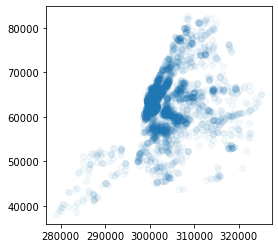

In [7]:
joined_venues = pd.concat([cf_unique, google_maps]).sort_values('name')
joined_venues['name'] = joined_venues['name'].str.title() # titlecase names

joined_venues.plot(alpha=0.05);
joined_venues.head()

### Plot on hexgrid

In [8]:
sjoined_hexes = gpd.sjoin(hexagons, joined_venues)

venue_count = sjoined_hexes['hex_id_8'].value_counts().reset_index()

venue_count.rename(columns={'index':'hex_id_8', 'hex_id_8':'venue_count'}, inplace=True)

gdf = pd.merge(hexagons,
               venue_count,
               how='left',
               on=['hex_id_8'])\
        .fillna(0)\
        .sort_values('venue_count', ascending=False)
    
gdf.head(3)

,hex_id_8,geometry,venue_count
1165,882a100d65fffff,"POLYGON ((301714.781 65863.222, 301880.715 663...",144.0
1193,882a1072cbfffff,"POLYGON ((300594.554 61028.530, 301133.174 611...",136.0
1129,882a100d2dfffff,"POLYGON ((301010.106 65250.815, 300471.361 651...",110.0


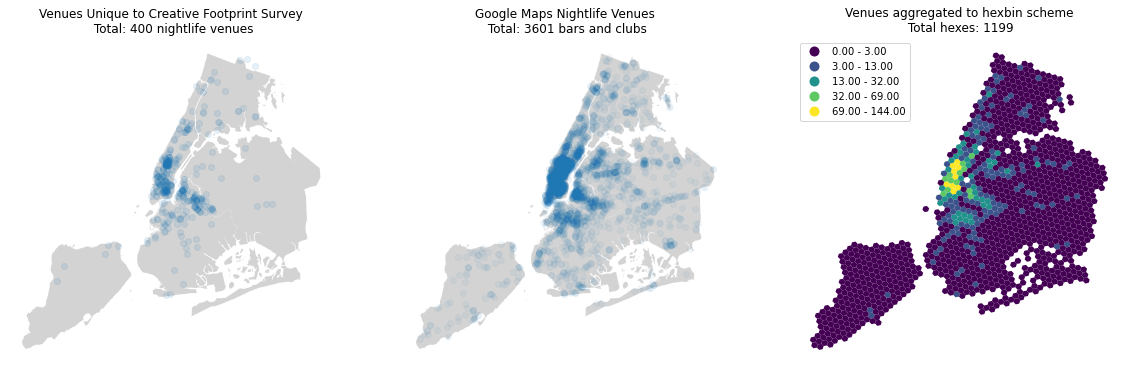

In [9]:
fig, ax = plt.subplots(1,3, figsize=(20,20))

boros = boros.to_crs(epsg=3627)
boros.plot(ax=ax[0], color='lightgrey');
boros.plot(ax=ax[1], color='lightgrey');

# Creative Footprint venues
cf_unique.plot(ax=ax[0], alpha=0.1);
ax[0].axis('off')
ax[0].title.set_text(f"Venues Unique to Creative Footprint Survey\n Total: {cf_unique.shape[0]} nightlife venues")

# Google Maps (bars and clubs) venues
google_maps.plot(ax=ax[1], alpha=0.05);
ax[1].axis('off')
ax[1].title.set_text(f"Google Maps Nightlife Venues\n Total: {google_maps.shape[0]} bars and clubs")

# Combined venues -> hexbins
gdf.plot(column='venue_count',
         ax=ax[2],
         scheme='fisher_jenks',
         legend=True,
         legend_kwds={'loc': 'upper left'});
ax[2].axis('off')
ax[2].title.set_text(f"Venues aggregated to hexbin scheme\n Total hexes: {gdf.shape[0]}")

In [10]:
# # merge in business data by hex and export

# out = gpd.GeoDataFrame(gdf.merge(businesses), crs="EPSG:3627")
# out.to_file("../data/shapefiles/nyc/venues_hexbinned.geojson",
#             driver='GeoJSON')

# out.plot(column='business_count');
# out.head(3)

In [33]:
import scipy.stats as st
def get_best_distribution(data):
    dist_names = ["norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"]
    dist_results = []
    params = {}
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        print("p value for "+dist_name+" = "+str(p))
        dist_results.append((dist_name, p))

    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))

    return best_dist, best_p, params[best_dist]

In [35]:
get_best_distribution(gdf['venue_count'])

p value for norm = 1.68274925612056e-160
p value for exponweib = 2.08987347e-316
p value for weibull_max = 0.0
p value for weibull_min = 2.08987347e-316
p value for pareto = 2.089906e-316
p value for genextreme = 4.705588188161852e-242
Best fitting distribution: norm
Best p value: 1.68274925612056e-160
Parameters for the best fit: (3.3269391159299415, 11.38945270485928)


/opt/anaconda3/envs/geo_env/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


('norm', 1.68274925612056e-160, (3.3269391159299415, 11.38945270485928))

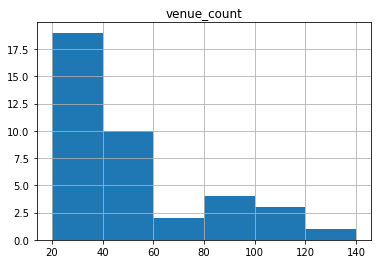

In [36]:
bins_list = [20, 40, 60, 80, 100, 120, 140]
gdf[gdf['venue_count'] > 1].hist(bins=bins_list);

#### Because the venue count data is normally distributed, we can use z-scores to find outliers (clusters of venues)

In [39]:
cf_survey['Name'].unique().shape

(494,)